<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 3: Generative Adversarial Networks
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [1]:
name = 'Zahra Maleki'
std_id = '400110009'

### In this notebook, you will implement the required components from scratch, without code completion. Utilize `torch` to create models and perform optimization. The goal of this assignment is to implement Deep Convolutional Generative Adversarial Networks (DC-GAN) using the MNIST dataset and to explore interpqolation in the latent space.

### To get started, please read the DC-GAN paper available at this link: [DC-GAN Paper](https://arxiv.org/abs/1511.06434v2).


In [31]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import argparse
import os
import random
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
from torchvision.utils import make_grid
import torchvision.utils as vutils

### Part 1. Load the MNIST dataset.

In [ ]:
workers = 2
batch_size = 128
image_size = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 4
lr = 0.0002
beta1 = 0.5
ngpu = 1

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class CustomMNISTDataset(Dataset):
    def __init__(self, mnist_data, transform=None):
        self.data = mnist_data.data
        self.targets = mnist_data.targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx].unsqueeze(0)  
        img = Image.fromarray(img.numpy().squeeze(), mode='L')  

        if self.transform:
            img = self.transform(img)

        return img, self.targets[idx]



transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

mnist_data = datasets.MNIST('', train=True, download=True)

dataset = CustomMNISTDataset(mnist_data, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)



### Part 2: Build the Generator and Discriminator models.
Build the models with the architecture guidelines for stable training as described in the paper. It is recommended to use the model parameters presented in `config.yaml`, but you are free to choose any set of parameters you prefer.


In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf* 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf *4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1,  bias=False),
            nn.BatchNorm2d(ngf *2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),

            nn.Tanh()

        )

    def forward(self, input):
        
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),

            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf *4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf* 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


### Part 3: Write a function to train the models using the GAN framework.
You can refer to the slides or the original GAN paper for the training schema: [GAN Paper](https://arxiv.org/abs/1406.2661). Additionally, create a function to generate samples from the model. Ensure to plot a grid of generated samples every n'th epoch.


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.


netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

netG.apply(weights_init)
netD.apply(weights_init)


optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [18]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):

    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)

        errD_real = criterion(output, label)

        errD_real.backward()
        D_x = output.mean().item()
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)

        errD_fake = criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake

        optimizerD.step()
        netG.zero_grad()

        label.fill_(real_label)
        output = netD(fake).view(-1)

        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Training Loop...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e74859ff010>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e74859ff010>    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        if w.is_alive():if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

[0/5][468/469]	Loss_D: 0.7807	Loss_G: 1.7754	D(x): 0.7399	D(G(z)): 0.3195 / 0.2009
[1/5][468/469]	Loss_D: 0.2115	Loss_G: 1.9299	D(x): 0.8481	D(G(z)): 0.0243 / 0.1871
[2/5][468/469]	Loss_D: 0.8716	Loss_G: 1.3356	D(x): 0.5401	D(G(z)): 0.0931 / 0.3403
[3/5][468/469]	Loss_D: 0.0838	Loss_G: 4.0929	D(x): 0.9654	D(G(z)): 0.0455 / 0.0247
[4/5][468/469]	Loss_D: 0.6495	Loss_G: 3.3348	D(x): 0.8273	D(G(z)): 0.3106 / 0.0554


### Part 4: Plot a grid of 100 generated samples.

In [21]:
def generate_and_plot_samples(netG, nz, device, num_samples=100, nrow=10):

    fixed_noise = torch.randn(num_samples, nz, 1, 1, device=device)

    with torch.no_grad():
        fake_images = netG(fixed_noise).detach().cpu()

    grid = vutils.make_grid(fake_images, nrow=nrow, padding=2, normalize=True)

    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(f"Generated Images")
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()


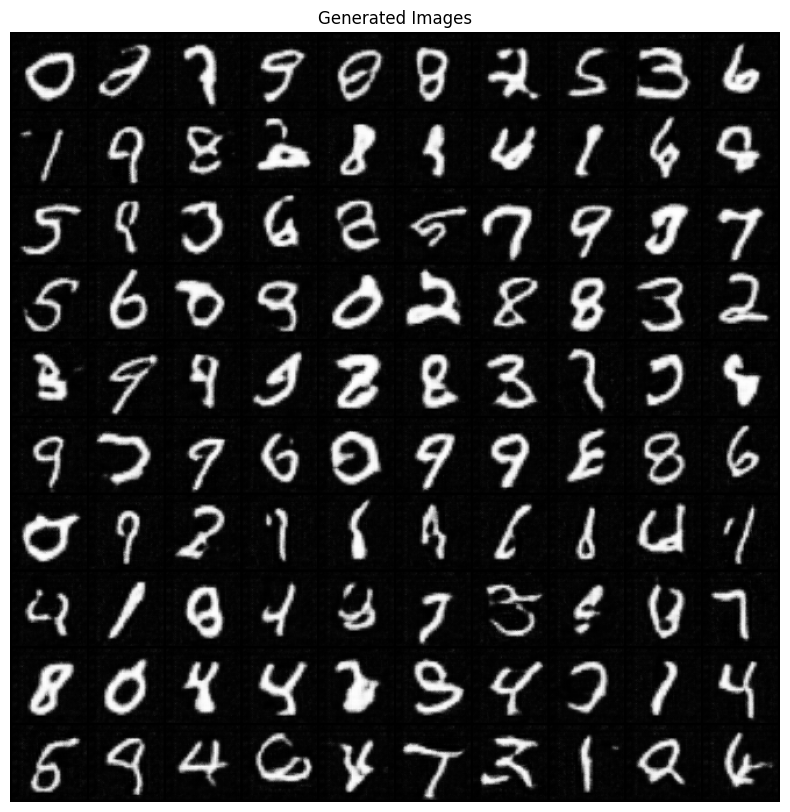

In [22]:
generate_and_plot_samples(netG, nz, device, num_samples=100, nrow=10)

### Part 5: GAN Inversion
In this part, we aim to find the latent vectors corresponding to the samples in the dataset. First, select a random sample from the real dataset and a random latent vector. Freeze the generator and feed the random latent vector into the Generator. Next, define an MSE or MAE loss between the generated sample and the real sample, and optimize the random latent vector to discover the latent vector that generates the selected real sample.


In [23]:
def gan_inversion(netG, real_sample, nz, device, num_iterations=500, lr=lr, loss_fn='MSE'):

    real_sample = real_sample.unsqueeze(0).to(device)

    latent_vector = torch.randn(1, nz, 1, 1, device=device, requires_grad=True)

    if loss_fn == 'MSE':
        criterion = torch.nn.MSELoss()
    elif loss_fn == 'MAE':
        criterion = torch.nn.L1Loss()
    else:
        raise ValueError("Loss function must be 'MSE' or 'MAE'.")

    optimizer = optim.Adam([latent_vector], lr=lr, betas=(0.5, 0.999))

    for iteration in range(num_iterations):
        optimizer.zero_grad()

        generated_image = netG(latent_vector)

        loss = criterion(generated_image, real_sample)

        loss.backward()

        optimizer.step()

        if (iteration + 1) % 50 == 0:
            print(f"Iteration {iteration + 1}/{num_iterations}, Loss: {loss.item()}")

    return latent_vector.detach(), generated_image.detach()

def plot_real_and_generated(real_sample, generated_image):

    real_sample = real_sample.squeeze().cpu().numpy()
    generated_image = generated_image.squeeze().cpu().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(real_sample, cmap='gray')
    axes[0].set_title("Real Sample")
    axes[0].axis("off")

    axes[1].imshow(generated_image, cmap='gray')
    axes[1].set_title("Generated Image")
    axes[1].axis("off")

    plt.show()



Iteration 50/500, Loss: 0.22521431744098663
Iteration 100/500, Loss: 0.2150326520204544
Iteration 150/500, Loss: 0.20629899203777313
Iteration 200/500, Loss: 0.19916237890720367
Iteration 250/500, Loss: 0.19316956400871277
Iteration 300/500, Loss: 0.1876891851425171
Iteration 350/500, Loss: 0.18244433403015137
Iteration 400/500, Loss: 0.17717400193214417
Iteration 450/500, Loss: 0.17214807868003845
Iteration 500/500, Loss: 0.16771522164344788


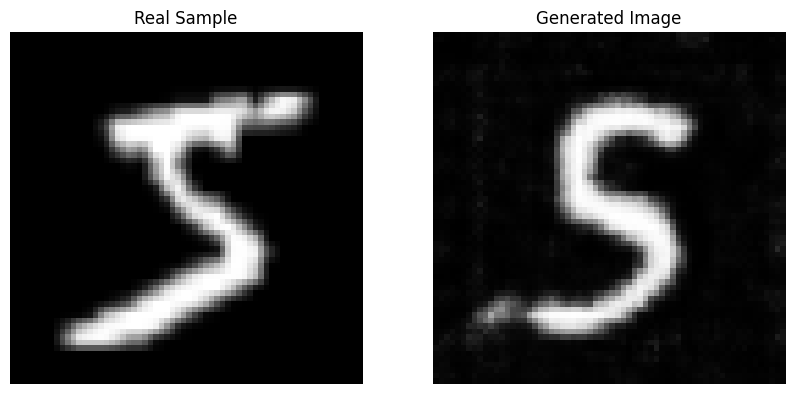

In [29]:
real_sample = dataset[0][0]
latent_vector, generated_image = gan_inversion(netG, real_sample, nz, device)
plot_real_and_generated(real_sample, generated_image)


In [30]:
torch.save(netG.state_dict(), '/content/generator.pth')
torch.save(netD.state_dict(), '/content/discriminator.pth')

### Part 6: Interpolating the Latent Space
In this part, you will interpolate the latent space using a 10 by 10 grid. Start with 4 initial points representing the corners of the square, and then perform linear or spherical interpolation between the latent vectors of these 4 images to fill the circumference of the square.
Next, fill in the rest of the square by interpolating between the latent vectors along the circumference.

If $G$ is the generator, and $z_1$ and $z_2$ are two latent vectors of two images, let $w$ be a parameter that varies between $0$ and $1$. The linearly interpolated sample is generated as:

\begin{equation}
G(w \cdot z_1 + (1 - w) \cdot z_2)\
\end{equation}

Try to select the 4 starting images from those that exhibit distinct features. For example, the two top right corners could be the same digit but one with a thick stroke and the other with a thin stroke, while the other two points should be from a different digit but with varying stroke styles.

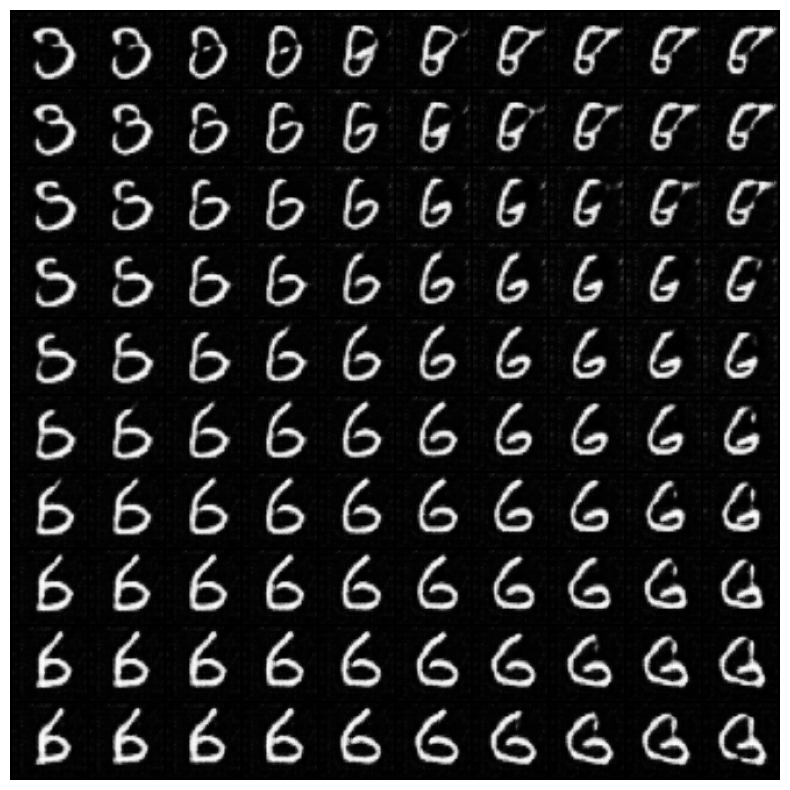

In [33]:
def interpolate_latent_space(z1, z2, steps=10):
    return [(1 - w) * z1 + w * z2 for w in np.linspace(0, 1, steps)]

z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)
z3 = torch.randn(1, nz, 1, 1, device=device)
z4 = torch.randn(1, nz, 1, 1, device=device)

steps = 10
interpolations_1 = interpolate_latent_space(z1, z2, steps)
interpolations_2 = interpolate_latent_space(z2, z4, steps)
interpolations_3 = interpolate_latent_space(z4, z3, steps)
interpolations_4 = interpolate_latent_space(z3, z1, steps)

grid = []
for i in range(steps):
    row = []
    for j in range(steps):
        z_top = interpolations_1[i]
        z_bottom = interpolations_3[i]
        z_left = interpolations_4[j]
        z_right = interpolations_2[j]

        z = (1 - j / (steps - 1)) * z_top + (j / (steps - 1)) * z_bottom
        z = (1 - i / (steps - 1)) * z_left + (i / (steps - 1)) * z_right

        grid.append(z)

grid_images = []
for z in grid:
    with torch.no_grad():
        fake_image = netG(z).detach().cpu()
        grid_images.append(fake_image)

grid_images_tensor = torch.cat(grid_images, dim=0)

grid_img = make_grid(grid_images_tensor, nrow=steps, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()


### Part 7: Arithmetic Operation in Latent Space
In this part, you will attempt to modify the thickness or thinness of a sample by identifying the direction in the latent space that corresponds to these attributes. Additionally, you can explore changing a digit to another (e.g., transforming a digit into a 3) by finding the direction in the latent space that corresponds to that digit.


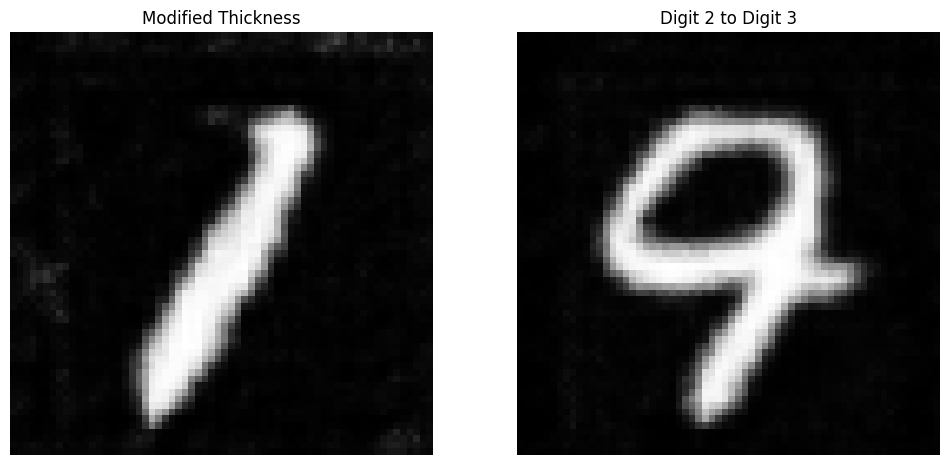

In [48]:
def perform_latent_arithmetic(latent_vector1, latent_vector2, weight=0.5):
    direction = latent_vector2 - latent_vector1
    new_latent_vector = latent_vector1 + weight * direction
    return new_latent_vector

z_thin = torch.randn(1, nz, 1, 1, device=device)
z_thick = torch.randn(1, nz, 1, 1, device=device)

z2 = torch.randn(1, nz, 1, 1, device=device)
z3 = torch.randn(1, nz, 1, 1, device=device)

modified_thickness_z = perform_latent_arithmetic(z_thin, z_thick, weight=1)
modified_digit_z = perform_latent_arithmetic(z2, z3, weight=1)

with torch.no_grad():
    generated_thickness_img = netG(modified_thickness_z).detach().cpu()
    generated_digit_img = netG(modified_digit_z).detach().cpu()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(generated_thickness_img.squeeze(0).permute(1, 2, 0).numpy(), cmap='gray')
axes[0].set_title('Modified Thickness')
axes[0].axis('off')

axes[1].imshow(generated_digit_img.squeeze(0).permute(1, 2, 0).numpy(), cmap='gray')
axes[1].set_title('Digit 2 to Digit 3')
axes[1].axis('off')

plt.show()
